In [16]:
# graphcl_xenium.py
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import random, os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
import umap
import scanpy as sc
import matplotlib.pyplot as plt

In [17]:
# ---------------------------
# === HYPERPARAMS
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

# Graph construction
knn_k = 8
prune_pct = 0.2

# Model / training
in_dim = None  # set automatically from X
hidden_dim = 128
proj_dim = 64        # projection head output dim (for contrastive loss)
latent_dim = 32      # encoder output dim (embedding)
epochs = 800
lr = 4e-3
batch_print = 25
weight_decay = 1e-6

# Augmentation params (tune)
edge_drop_prob = 0.2     # fraction of edges to randomly drop
feat_mask_rate = 0.2     # fraction of features to mask per node
temperature = 0.2

# Contrastive training specifics
use_symm_loss = True     # compute symmetric NT-Xent (recommended)

# Output
out_emb_path = "Results_deep_model/xenium_graphcl_embeddings.npy"

# ---------------------------
# === HELPERS: graph builder
# ---------------------------
import torch.nn.functional as F

def build_mutual_knn_weighted(coords, k=8, prune_pct=0.2, device=None):
    if isinstance(coords, np.ndarray):
        coords_t = torch.from_numpy(coords).float()
    else:
        coords_t = coords.float()
    if device:
        coords_t = coords_t.to(device)
    n = coords_t.size(0)
    dists = torch.cdist(coords_t, coords_t)  # (n,n)
    dists.fill_diagonal_(float('inf'))
    knn_idx = torch.topk(dists, k=k, largest=False).indices  # (n,k)
    knn_lists = [set(knn_idx[i].cpu().tolist()) for i in range(n)]
    edges = set()
    for u in range(n):
        for v in knn_idx[u].cpu().tolist():
            if u in knn_lists[v]:
                a,b = (u,v) if u<v else (v,u)
                edges.add((a,b))
    if len(edges) == 0:
        for u in range(n):
            for v in knn_idx[u].cpu().tolist():
                a,b = (u,v) if u<v else (v,u)
                edges.add((a,b))
    kth = dists[torch.arange(n), knn_idx[:, -1]]
    sigma = float(kth.median().item())
    if sigma <= 0: sigma = 1.0
    A = torch.zeros((n,n), dtype=torch.float32, device=device)
    for (u,v) in edges:
        dist = torch.dist(coords_t[u], coords_t[v])
        w = float(torch.exp(- (dist**2) / (2.0 * sigma**2 + 1e-12)))
        A[u,v] = w; A[v,u] = w
    if prune_pct > 0.0:
        all_w = A[A>0].cpu().numpy()
        if len(all_w)>0:
            thresh = np.percentile(all_w, prune_pct*100)
            A[A < thresh] = 0.0
    return A

def normalize_adj_dense(A):
    n = A.size(0)
    A_hat = A + torch.eye(n, device=A.device)
    deg = A_hat.sum(dim=1)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    return torch.diag(deg_inv_sqrt) @ A_hat @ torch.diag(deg_inv_sqrt)

# ---------------------------
# === AUGMENTATIONS
# ---------------------------
def drop_edges(A, drop_prob):
    # A: dense torch (n,n)
    if drop_prob <= 0.0:
        return A.clone()
    A2 = A.clone()
    # sample edges to drop among positive weights
    pos_idx = (A2 > 0).nonzero(as_tuple=False)
    m = pos_idx.size(0) // 2  # because symmetric pairs are counted twice; we'll handle symmetric drop explicitly
    if m == 0:
        return A2
    # build unique undirected edge list
    tri_u, tri_v = torch.triu_indices(A2.size(0), A2.size(1), offset=1)
    mask = (A2[tri_u, tri_v] > 0)
    tri_u = tri_u[mask]; tri_v = tri_v[mask]
    num_edges = tri_u.size(0)
    keep = max(1, int((1.0 - drop_prob) * num_edges))
    # randomly sample keep edges
    perm = torch.randperm(num_edges, device=A.device)[:keep]
    keep_u = tri_u[perm]; keep_v = tri_v[perm]
    A_new = torch.zeros_like(A2)
    A_new[keep_u, keep_v] = A2[keep_u, keep_v]
    A_new[keep_v, keep_u] = A2[keep_u, keep_v]
    return A_new

def mask_features(X, mask_rate):
    # X: (n, g) torch
    if mask_rate <= 0.0:
        return X.clone()
    X2 = X.clone()
    n, g = X2.size()
    # mask per node some features to zero (or add noise); here zero
    num_mask = int(mask_rate * g)
    if num_mask <= 0:
        return X2
    for i in range(n):
        idx = torch.randperm(g)[:num_mask]
        X2[i, idx] = 0.0
    return X2

# ---------------------------
# === GCN encoder + proj head
# ---------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=bias)
    def forward(self, X, A_norm):
        return F.relu(self.linear(A_norm @ X))

class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, latent_dim)
    def forward(self, X, A_norm):
        h = self.gcn1(X, A_norm)
        z = self.gcn2(h, A_norm)  # (n, latent_dim)
        return z

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, proj_dim)
        )
    def forward(self, x):
        return self.net(x)

# ---------------------------
# === Contrastive loss (NT-Xent)
# ---------------------------
def nt_xent_loss(z1, z2, temperature=0.2):
    """
    z1, z2: (n, d) projected vectors (not normalized necessarily)
    returns scalar loss (average over 2n positives if symmetric)
    """
    # normalize
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.size(0)
    z = torch.cat([z1, z2], dim=0)  # (2n, d)
    sim = z @ z.t()  # (2n,2n)
    sim /= temperature
    # create mask to exclude self-similarity
    mask = (~torch.eye(2*batch_size, dtype=torch.bool, device=sim.device)).float()
    # numerator: positives are (i, i+batch) and (i+batch, i)
    positives = torch.cat([torch.diag(sim, batch_size), torch.diag(sim, -batch_size)], dim=0)  # (2n,)
    # denominator: sum over row excluding self
    exp_sim = torch.exp(sim) * mask
    denom = exp_sim.sum(dim=1)
    loss = - torch.log(torch.exp(positives) / (denom + 1e-15))
    loss = loss.mean()
    return loss

# ---------------------------
# === Training function
# ---------------------------
def train_graphcl(X_np, coords_np, labels_np=None):
    X = torch.from_numpy(X_np).float().to(device)
    coords = torch.from_numpy(coords_np).float().to(device)
    n = X.shape[0]
    global in_dim
    in_dim = X.shape[1]

    # Build base adjacency
    A = build_mutual_knn_weighted(coords_np, k=knn_k, prune_pct=prune_pct, device=device)
    degs = (A > 0).sum(dim=1).float()
    print(f"Built adjacency: avg deg {degs.mean().item():.2f}")

    A_norm = normalize_adj_dense(A)

    # model
    encoder = GCNEncoder(in_dim=in_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    proj = ProjectionHead(latent_dim, proj_dim).to(device)

    opt = torch.optim.Adam(list(encoder.parameters()) + list(proj.parameters()), lr=lr, weight_decay=weight_decay)

    best_loss = 1e9; patience_cnt = 0; patience = 80

    for epoch in range(1, epochs+1):
        encoder.train(); proj.train()
        opt.zero_grad()

        # Augmented view 1
        A1 = drop_edges(A, drop_prob=edge_drop_prob)
        A1_norm = normalize_adj_dense(A1)
        X1 = mask_features(X, mask_rate=feat_mask_rate)

        # Augmented view 2
        A2 = drop_edges(A, drop_prob=edge_drop_prob)
        A2_norm = normalize_adj_dense(A2)
        X2 = mask_features(X, mask_rate=feat_mask_rate)

        # forward
        z1 = encoder(X1, A1_norm)   # (n, latent_dim)
        z2 = encoder(X2, A2_norm)
        p1 = proj(z1)
        p2 = proj(z2)

        loss = nt_xent_loss(p1, p2, temperature=temperature)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(proj.parameters()), max_norm=5.0)
        opt.step()

        if epoch % batch_print == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | loss {loss.item():.4f}")

        # early stopping
        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item(); patience_cnt = 0
            # optionally save best weights
            torch.save({'enc': encoder.state_dict(), 'proj': proj.state_dict()}, 'best_graphcl.pt')
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print(f"Early stopping at epoch {epoch} (patience {patience})")
                break

    # load best
    try:
        ckpt = torch.load('best_graphcl.pt', map_location=device)
        encoder.load_state_dict(ckpt['enc'])
        proj.load_state_dict(ckpt['proj'])
    except Exception:
        pass

    # final embeddings (encoder output before projection)
    encoder.eval()
    with torch.no_grad():
        Z_final = encoder(X, normalize_adj_dense(A)).cpu().numpy()

    # save
    np.save(out_emb_path, Z_final)
    print("Saved embeddings to", out_emb_path)

    # evaluations
    for k in [4,6,8,10]:
        try:
            km = KMeans(n_clusters=k, random_state=seed, n_init=20).fit(Z_final)
            sil = silhouette_score(Z_final, km.labels_)
            print(f"k={k} silhouette: {sil:.4f}")
        except Exception as e:
            print("KMeans failed for k", k, e)

    # UMAP
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, random_state=seed)
    Z_umap = reducer.fit_transform(Z_final)
    plt.figure(figsize=(6,5))
    if labels_np is not None:
        plt.scatter(Z_umap[:,0], Z_umap[:,1], c=labels_np, s=8)
        plt.title("GraphCL embeddings (UMAP) colored by GT labels (validation only)")
    else:
        plt.scatter(Z_umap[:,0], Z_umap[:,1], s=8)
        plt.title("GraphCL embeddings (UMAP)")
    plt.show()

    # optional ARI/NMI if labels provided
    if labels_np is not None:
        km = KMeans(n_clusters=len(np.unique(labels_np)), random_state=seed, n_init=20).fit(Z_final)
        ari = adjusted_rand_score(labels_np, km.labels_)
        nmi = normalized_mutual_info_score(labels_np, km.labels_)
        print("ARI:", ari, "NMI:", nmi)

    return Z_final

In [18]:
# ---------------------------
# Data loading & preprocessing
# ---------------------------
def load_and_preprocess(spat_path="SmallData/xenium_spatial_common_genes.h5ad"):
    A = sc.read_h5ad(spat_path)

    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)

    Ac = A.copy()
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    X_spat = Ac.X.toarray().astype(np.float32)
    
    # *** CRITICAL: scale features ***
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_spat = scaler.fit_transform(X_spat).astype(np.float32)

    y_spat = Ac.obs[spat_label_col].astype(str).values if spat_label_col in Ac.obs.columns else None
    all_labels = np.unique(y_spat)
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}
    y_spat_id = np.array([label_to_id[l] for l in y_spat]) if y_spat is not None else None

    coords = Ac.obsm["spatial"]

    return (label_to_id, X_spat, y_spat_id, Ac.obs_names.values, coords, all_labels)


In [19]:
## Loading the data
label_to_id, X_spat, y_spat, spat_ids, coords, all_labels = load_and_preprocess(
         spat_path="SmallData/xenium_spatial_common_genes.h5ad"
    )

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


Built adjacency: avg deg 5.13
Epoch    1 | loss 8.2288
Epoch   25 | loss 5.2528
Epoch   50 | loss 4.6778
Epoch   75 | loss 4.4550
Epoch  100 | loss 4.3320
Epoch  125 | loss 4.2679
Epoch  150 | loss 4.2331
Epoch  175 | loss 4.1752
Epoch  200 | loss 4.1721
Epoch  225 | loss 4.1420
Epoch  250 | loss 4.1411
Epoch  275 | loss 4.1319
Epoch  300 | loss 4.1138
Epoch  325 | loss 4.1124
Epoch  350 | loss 4.0998
Epoch  375 | loss 4.0988
Epoch  400 | loss 4.0912
Epoch  425 | loss 4.0859
Epoch  450 | loss 4.0838
Epoch  475 | loss 4.0777
Epoch  500 | loss 4.0743
Epoch  525 | loss 4.0754
Epoch  550 | loss 4.0673
Epoch  575 | loss 4.0664
Epoch  600 | loss 4.0671
Epoch  625 | loss 4.0593
Epoch  650 | loss 4.0563
Epoch  675 | loss 4.0579
Epoch  700 | loss 4.0647
Epoch  725 | loss 4.0593
Epoch  750 | loss 4.0590
Epoch  775 | loss 4.0420
Epoch  800 | loss 4.0527
Saved embeddings to Results_deep_model/xenium_graphcl_embeddings.npy
k=4 silhouette: 0.1413
k=6 silhouette: 0.1095
k=8 silhouette: 0.1261
k=10 si

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


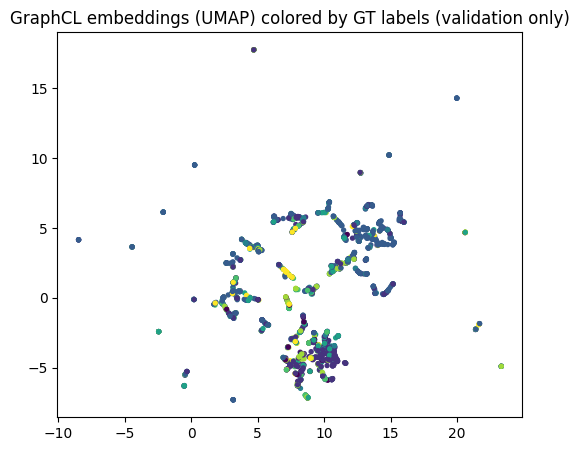

ARI: 0.1424589364874655 NMI: 0.17840465923087623
Done. Embeddings shape: (2000, 32)


In [20]:
Z = train_graphcl(X_spat, coords, y_spat)
print("Done. Embeddings shape:", Z.shape)

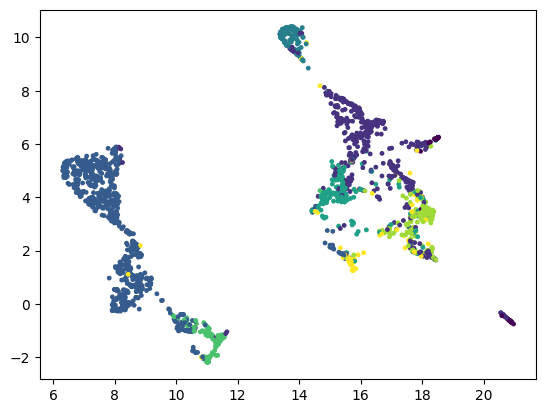

In [22]:
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

pca = PCA(n_components=20)
Xp = pca.fit_transform(X_spat)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.0)
Xp_umap = reducer.fit_transform(Xp)

plt.scatter(Xp_umap[:,0], Xp_umap[:,1], c=y_spat, s=6)
plt.show()


PCA variance ratio (first 10): [0.0958 0.0393 0.029  0.0215 0.0202 0.0166 0.0125 0.0094 0.009  0.0079]
PCA cumulative var explained (10 comp): 0.2612


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


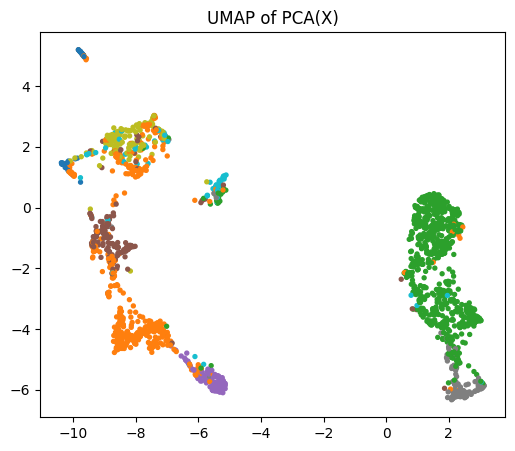

In [23]:
# assumes: X_spat (n,g) float32, y_spat (n,) int or None
import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

# PCA -> UMAP pipeline
pca = PCA(n_components=30, random_state=0)
Xp = pca.fit_transform(X_spat)

print("PCA variance ratio (first 10):", np.round(pca.explained_variance_ratio_[:10], 4))
print("PCA cumulative var explained (10 comp):", np.round(pca.explained_variance_ratio_[:10].sum(), 4))

reducer = umap.UMAP(n_neighbors=15, min_dist=0.0, random_state=0)
Xp_umap = reducer.fit_transform(Xp)

plt.figure(figsize=(6,5))
if 'y_spat' in globals() and y_spat is not None:
    plt.scatter(Xp_umap[:,0], Xp_umap[:,1], c=y_spat, s=8, cmap='tab10')
else:
    plt.scatter(Xp_umap[:,0], Xp_umap[:,1], s=8)
plt.title("UMAP of PCA(X)"); plt.show()


In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(X_spat)  # ensure scaled version used

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
acc_knn = cross_val_score(knn, Xs, y_spat, cv=skf, scoring='accuracy')
print("KNN 5-fold accuracy:", np.round(acc_knn.mean(),3), "±", np.round(acc_knn.std(),3))

log = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')
acc_log = cross_val_score(log, Xs, y_spat, cv=skf, scoring='accuracy')
print("Logistic 5-fold accuracy:", np.round(acc_log.mean(),3), "±", np.round(acc_log.std(),3))


KNN 5-fold accuracy: 0.708 ± 0.015


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/

Logistic 5-fold accuracy: 0.871 ± 0.008


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# choose number of GT clusters
n_clusters = len(np.unique(y_spat))
km = KMeans(n_clusters=n_clusters, random_state=0, n_init=20).fit(Xp[:, :20])  # use first 20 PCs
ari = adjusted_rand_score(y_spat, km.labels_)
nmi = normalized_mutual_info_score(y_spat, km.labels_)
print("KMeans on PCA ARI:", np.round(ari,3), "NMI:", np.round(nmi,3))


KMeans on PCA ARI: 0.688 NMI: 0.638


In [28]:
from sklearn.metrics import silhouette_samples
import pandas as pd

# cluster labels to test: use GT labels
sil_vals = silhouette_samples(Xp[:, :20], y_spat)
df = pd.DataFrame({'label': y_spat, 'sil': sil_vals})
summary = df.groupby('label').sil.agg(['mean','median','count']).sort_values('mean', ascending=False)
print(summary)


           mean    median  count
label                           
2      0.428321  0.479900    752
3      0.219978  0.270398    124
5      0.167997  0.215011    125
6      0.163573  0.179791    177
0      0.124190  0.150722     62
4      0.101959  0.152125    175
7      0.074509  0.037309     89
1      0.021745  0.024583    496


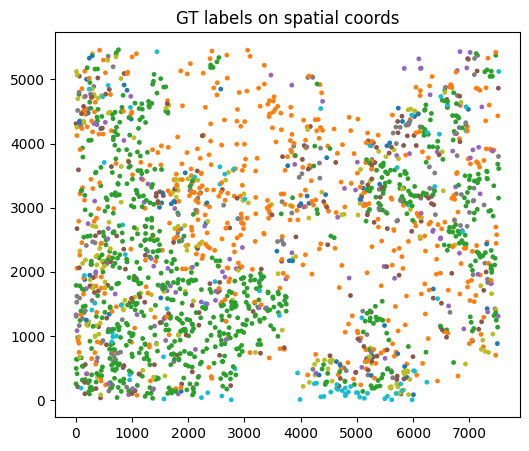

In [30]:
import numpy as np
plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], c=y_spat, s=6, cmap='tab10')
plt.title("GT labels on spatial coords")
plt.show()
